In [1]:
import os
import copy
import numpy as np
from numpy.linalg import norm
import pandas as pd

import SingleOrigin as so
%matplotlib widget

This workbook illustrates how atomic column positions were measured for a complicated structure: the tetragonal tungsten bronze $Ba_5SmSn_3Nb_7O_{30}$ (BSSN). The dataset contains 5 differential phase contrast (DPC) images.

- Here we also demonstrate some of the atomic resolution image analyais features in SingleOrigin, including some uses of the vPCF.

- First, specify the folder containing the images.

In [2]:
data_folder = 'BSSN_DPC_images'

- Set up the proected unit cell. This is slightly complicated because of the TTB structure, our desire to label the atom columns according to the TTB convention and the need to include only some of the oxygen atom columns (others are not resolved in the STEM images).

In [3]:
za = [1, 1, 0]  # Zone Axis direction
a1 = [-1, 1, 0]  # Apparent horizontal axis in projection
a2 = [0, 0, 1]  # Most vertical axis in projection

cif = 'BSSN5137.cif'

uc = so.UnitCell(cif)


def LatticeSiteLabeling(unitcell):
    # Apply logical framework to categorize project atoms by sublattices
    lattice_site = []

    for ind in unitcell.index:
        if unitcell.at[ind, 'elem'] == 'Sm|Ba':
            lattice_site.append('A1')
        elif unitcell.at[ind, 'elem'] == 'Ba':
            # if np.isin(unitcell.at[ind, 'v'], [0.25, 0.75]):
            if unitcell.at[ind, 'u'] == 0.5:
                lattice_site.append('A2_1')
            else:
                lattice_site.append('A2_2')
        elif unitcell.at[ind, 'elem'] == 'Sn|Nb':
            # if np.isin(unitcell.at[ind, 'v'], [0.25, 0.75]):
            if unitcell.at[ind, 'u'] == 0.5:
                lattice_site.append('B1')
            else:
                lattice_site.append('B2')
        elif unitcell.at[ind, 'elem'] == 'O':
            if unitcell.at[ind, 'u'] < 0.5:
                lattice_site.append('O1')
            elif unitcell.at[ind, 'u'] > 0.5:
                lattice_site.append('O2')

        # else:
        #     print(unitcell.loc[ind, :])

    unitcell.loc[:, 'LatticeSite'] = lattice_site
    return unitcell


# Transform Unit Cell with and without oxygen
uc_O = copy.copy(uc)

uc.project_zone_axis(za, a1, a2, ignore_elements=['O'], reduce_proj_cell=True)
uc.combine_prox_cols(toler=1e-1)

uc_O.project_zone_axis(za, a1, a2, ignore_elements=[], reduce_proj_cell=True)
uc_O.combine_prox_cols(toler=1e-1)

# Filtering to remove unresolved oxygen columns in [110] TTB projection
df_O = uc_O.at_cols[(uc_O.at_cols.elem == 'O')].copy()
df_cation = uc.at_cols[uc.at_cols.elem != 'O'].copy()

df_O = df_O[(np.isclose(df_O.u, 0.2785, atol=0.001)) |
            (np.isclose(df_O.u, 0.7215, atol=0.001))]

df_all = pd.concat([df_cation, df_O], axis=0)


uc.at_cols = df_all
uc.at_cols.reset_index(drop=True, inplace=True)
uc.at_cols = LatticeSiteLabeling(uc.at_cols)

uc.at_cols.loc[:, 'u':'v'] = (
    uc.at_cols.loc[:, 'u':'v'] + np.array([0.5, 0.5])
) % 1

uc.at_cols.loc[:, 'x':'y'] = uc.at_cols.loc[:, 'u':'v'].to_numpy() @ uc.a_2d

label_dict = {'A1': 'A1',
              'A2_1': r'A2$_1$',
              'A2_2': r'A2$_2$',
              'B1': 'B1',
              'B2': 'B2',
              'O1': 'O1',
              'O2': 'O2',
              }
color_dict = {'A1': 'royalblue',
              'A2_1': 'blue',
              'A2_2': 'deepskyblue',
              'B1': 'green',
              'B2': 'lawngreen',
              'O1': 'red',
              'O2': 'red',
              }

transformed lattice parameters: 
 a1:     17.8016 
 a2:     17.8016 
 a3:     3.9622 
 alpha:  90.0 
 beta:   90.0 
 gamma:  90.0 

transformed lattice parameters: 
 a1:     17.8016 
 a2:     17.8016 
 a3:     3.9622 
 alpha:  90.0 
 beta:   90.0 
 gamma:  90.0 



- Plot the projected unit cell so verify

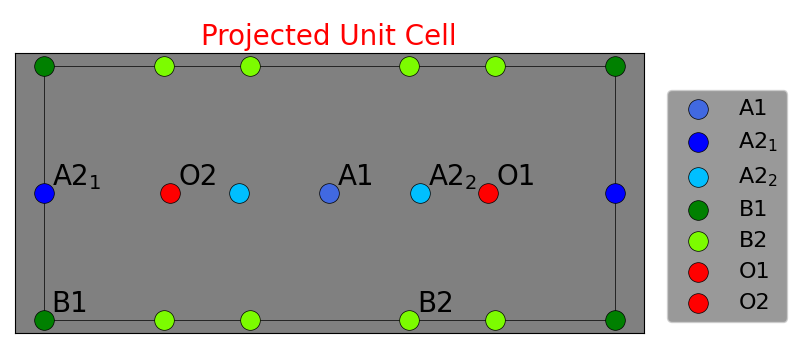

In [4]:
uc.plot_unit_cell(
    label_by='LatticeSite',
    label_dict=label_dict,
    color_dict=color_dict
)

- Make a dictionary to hold data from all 5 images.

In [5]:
at_cols_frames = {}

- Get list of all image files from the working directory.

In [6]:
file_list = []
for file in os.listdir(data_folder):
    if np.isin(file.split('.')[-1], ['tif']).item() and file[:4] == 'data':
        file_list += [file]
    else:
        continue
file_list.sort()


file = iter([i for i in file_list])

- Load the first image. To analize all the images in the folder return to this step after writing the atom column positions to the dictionary. Once all the images have been analized run the final cell to save the dictionary to disk. Analysis of the summed vPCF (i.e. from all images) is in a separate notebook.

In [7]:
filename = next(file)
[scan_num, scan_id] = [int(''.join(i for i in s if i.isdigit() or i in ''))
                       for s in filename.split('_')[1:3]]

image, _ = so.load_image(os.path.join(data_folder, filename),
                         plot=False)

- Initiate the image analysis object and pick basis peaks from the FFT

Select 2 points. Right click to remove. Enter when finished.



Degrees of freedom <= 0 for slice
invalid value encountered in divide
invalid value encountered in scalar divide


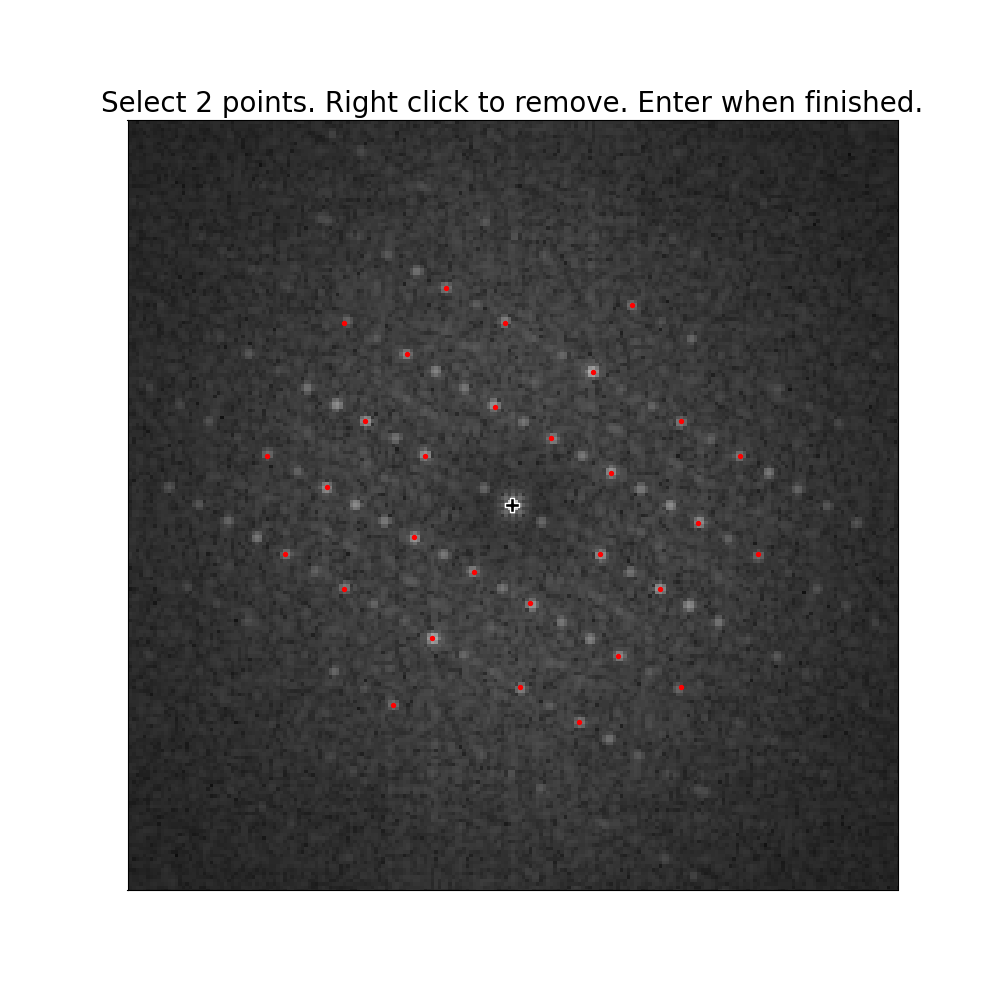

In [8]:
hrimage = so.HRImage(image, pixelSize_cal=0.013184941*10 / 2)
bssn = hrimage.add_lattice('BSSN', uc,
                           origin_atom_column=None)

bssn.fft_get_peaks(thresh_factor=0.5,
                   sigma=5)

- Establish the reciprocal lattice using the selected basis vectors

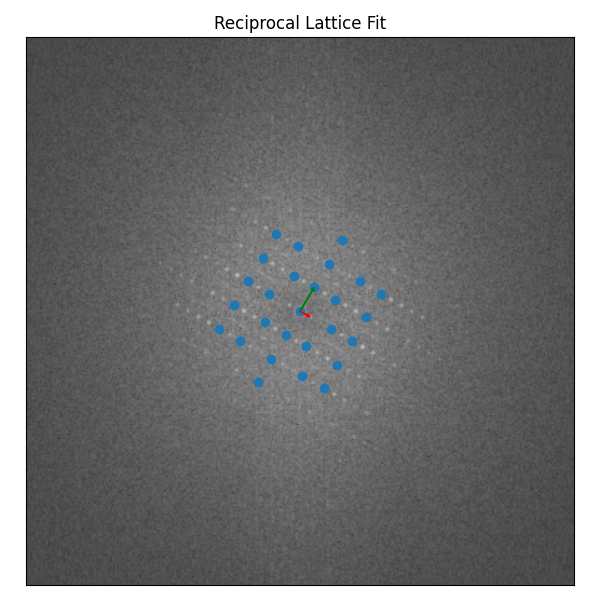

In [9]:
bssn.fft_get_basis_vect(a1_order=3, a2_order=1, sigma=5)


- Select the lattice origin to establish an initial real space lattice

Select 1 points. Right click to remove. Enter when finished.


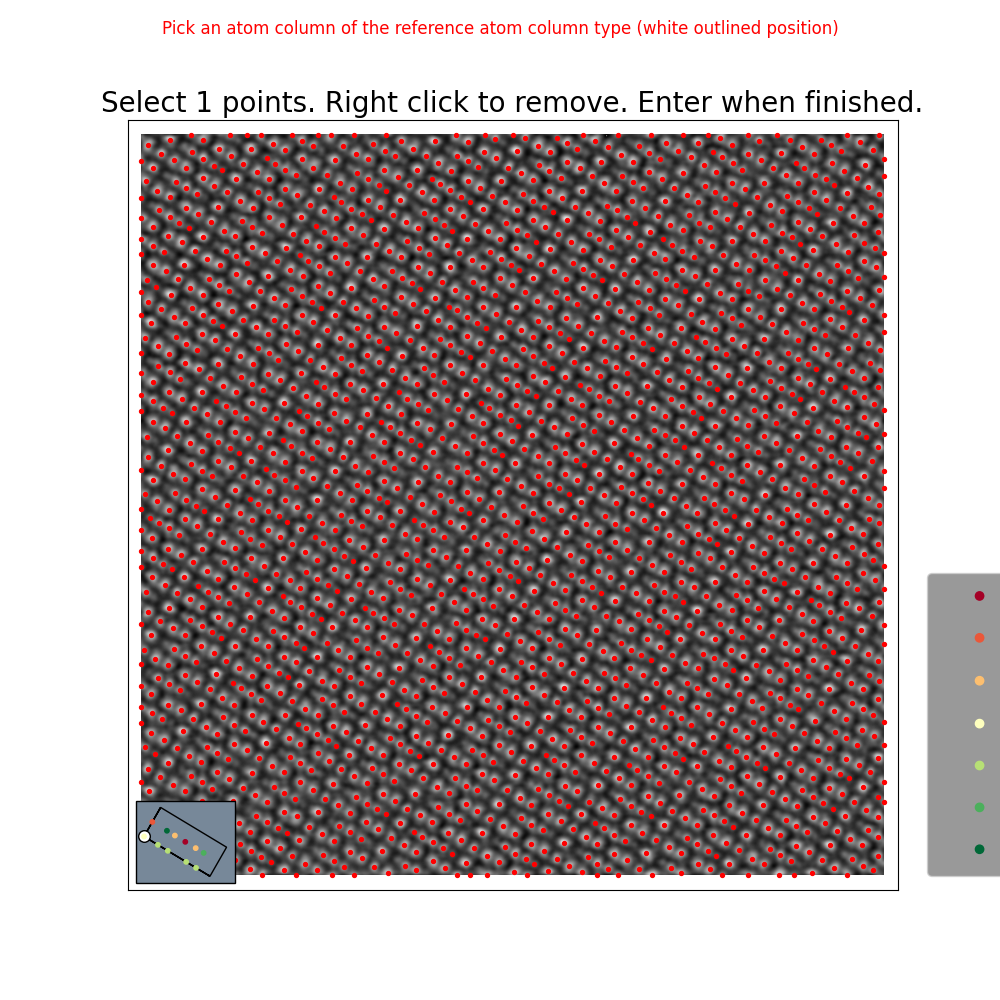

In [10]:
bssn.select_lattice_origin()


- Create the real space lattice

Creating reference lattice...
Performing rough reference lattice refinement...


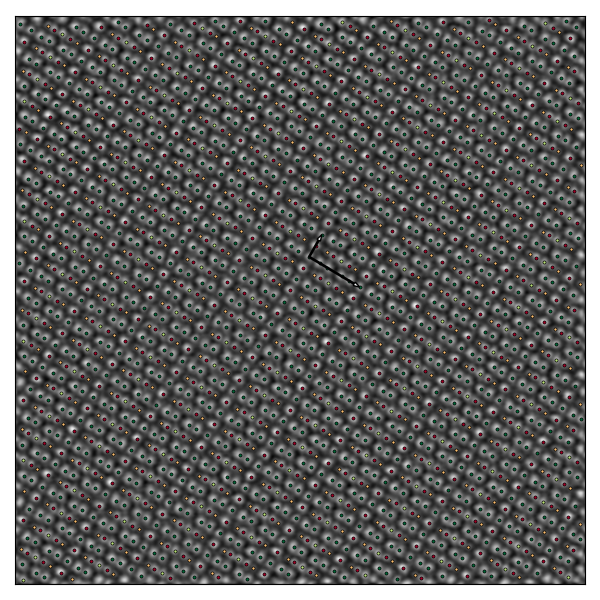

In [11]:
bssn.make_reference_lattice(plot_ref_lattice=True, buffer=10)


- Fit the atom columns

In [12]:
bssn.fit_atom_columns(
    bkgd_thresh_factor=0.5,
    peak_sharpening_filter='auto',
    peak_grouping_filter='auto',
    parallelize=True,
    use_circ_gauss=True,
    use_bounds=True,
    pos_bound_dist=0.5,
    watershed_line=True,
)

Preparing to fit atom columns...
Step 1 (Initial checks): 0.16 sec
Step 2 (fitting masks): 2.00 sec
Step 3 (grouping masks): 1.14 sec
Atomic columns grouped for simultaneous fitting:
1447x 1-column groups
395x 2-column groups
10x 3-column groups
Step 4 (Final prep): 0.18 sec
Fitting atom columns...
Using parallel processing


  0%|          | 0/1852 [00:00<?, ?it/s]

Step 5 (Fitting): 12.48 sec
Step 6 (Post-processing): 0.02 sec 
 Done.


- Refine the lattice using the fitted positions

In [13]:
bssn.refine_reference_lattice('LatticeSite', 'A1')


Origin shift: [0.07623893 0.03196138]
Optimized basis vectors: [[121.55524513  72.75838797]
 [ 30.60355305 -53.55950868]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: -2.2321 %
Shear component: -0.020242 (radians)
Estimated Pixel Size: 6.353 (pm)


- Plot the fits on the image

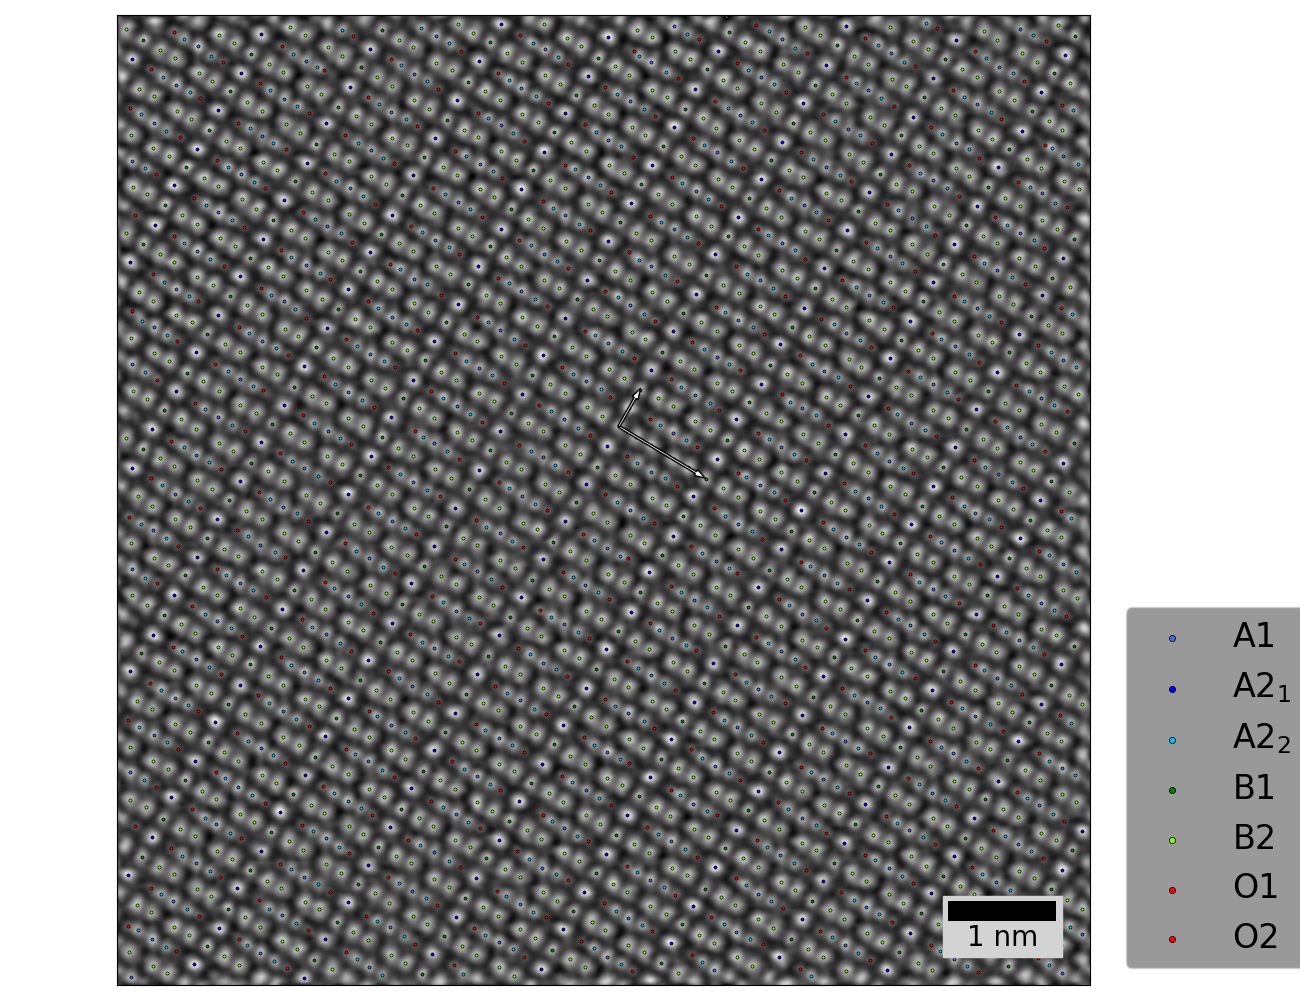

In [14]:
fig, ax = hrimage.plot_atom_column_positions(
    filter_by='LatticeSite',
    sites_to_plot='all',
    fit_or_ref='fit',
    plot_masked_image=False,
    legend_dict=label_dict,
    color_dict=color_dict,
    scalebar_len_nm=1,
    figax=True,
)

- Save the figure of plotted positions (if desired)

In [15]:
so.save_fig(fig, '', f'scan{scan_num}_fitted_pos_fig.png', dpi=300)


- Rotate the image and data for better vPCF analysis

In [16]:
acl_rot, bssn_rot = hrimage.rotate_image_and_data(
    align_basis='a1',
    align_dir='right',
    lattice_to_align='BSSN')

Rotation angle: 30.90314919069246


- Calculate the vPCFs

In [17]:
acl_rot.latt_dict['BSSN_rot'].get_vpcfs(
    xlim=[-2.25, 6.5],
    ylim=[-1.25, 6.25],
    d=0.02,
    area=None,
    filter_by='LatticeSite',
    sublattice_list=['A2_1'],
    get_only_partial_vpcfs=False,
    affine_transform=True,
    outlier_disp_cutoff=0.4,
    centrosymmetric=True,
)

Calculating A2_1 vPCF
Appling affine transformation to data...


- Measure the vPCF peak shapes

In [18]:
acl_rot.latt_dict['BSSN_rot'].get_vpcf_peak_params(
    sigma=10,
    buffer=20,
    method='moments',
    sigma_group=None,
    detection_thresh_factor=0.01
)

A2_1
Calculating peaks for A2_1 vPCF


0it [00:00, ?it/s]

metadata


- Plot the vPCFs for a visual check. Keep in mind that the modulation will be more apparent in some vPCFs than others. The best signal will be found for the summed vPCFs once all images are analized. It is not necessary to calculate all the vPCFs now. The summed vPCFs will be calculated later from the atom positions meausred from all images.

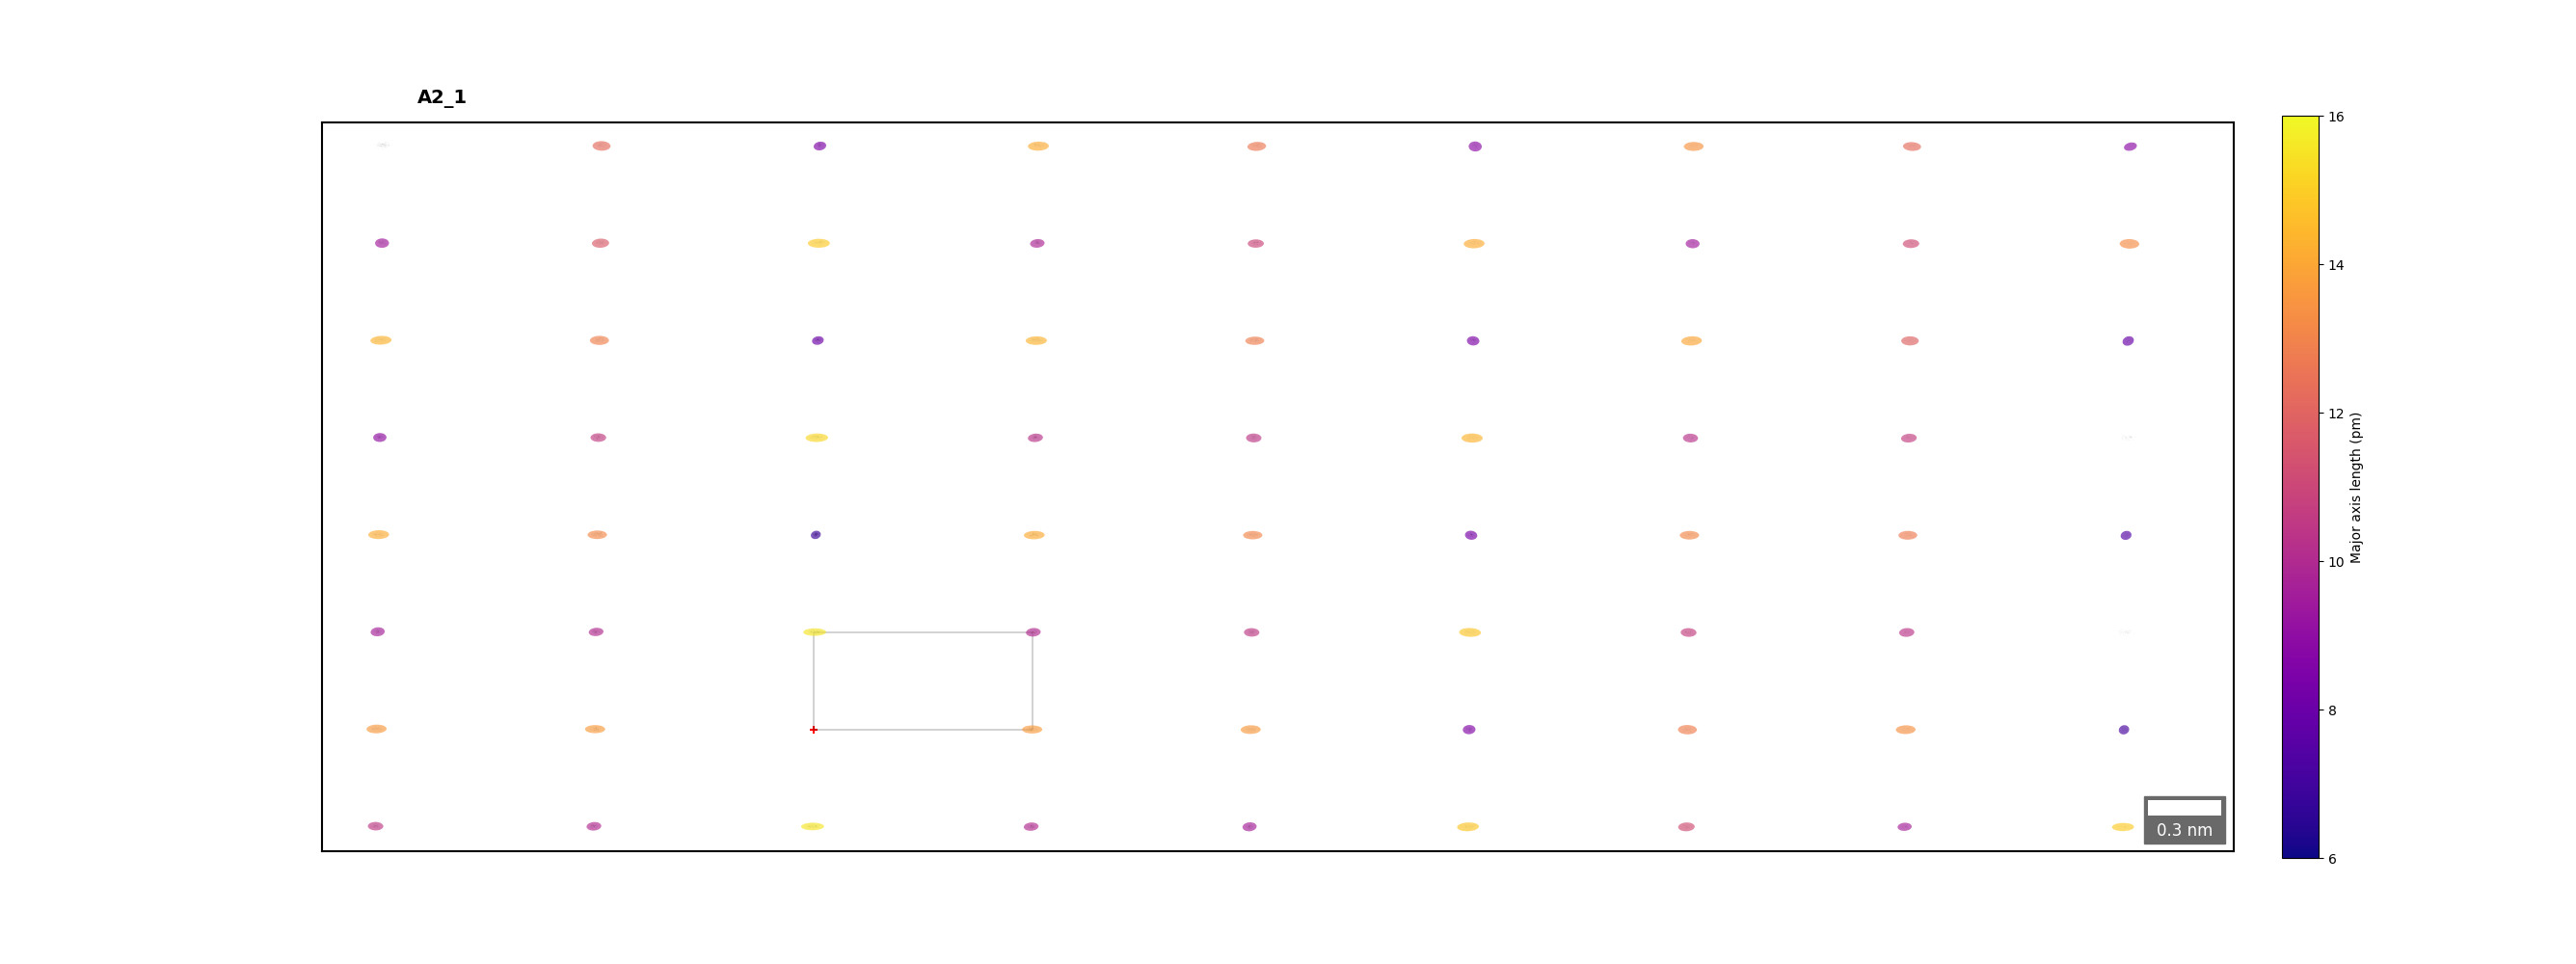

In [19]:
fig, axs, axs_cbar = acl_rot.latt_dict['BSSN_rot'].plot_vpcfs(
    vpcfs_to_plot='all',
    plot_equ_ellip=True,
    vpcf_cmap='Greys',
    ellip_colormap_param='sig_maj',
    # colormap_range=[6,12],
    ellip_scale_factor=3,
    unit_cell_box=True,
    scalebar_len=0.3
)

- You can also use vPCF peaks to plot corrresponding inter-atom column distances on the image. This is a good way to visualize the modulation. 

- Here we pick the A2_1 distances. The first peak to the right or left of the origin should be selected for this purpose.

Select 1 points. Right click to remove. Enter when finished.



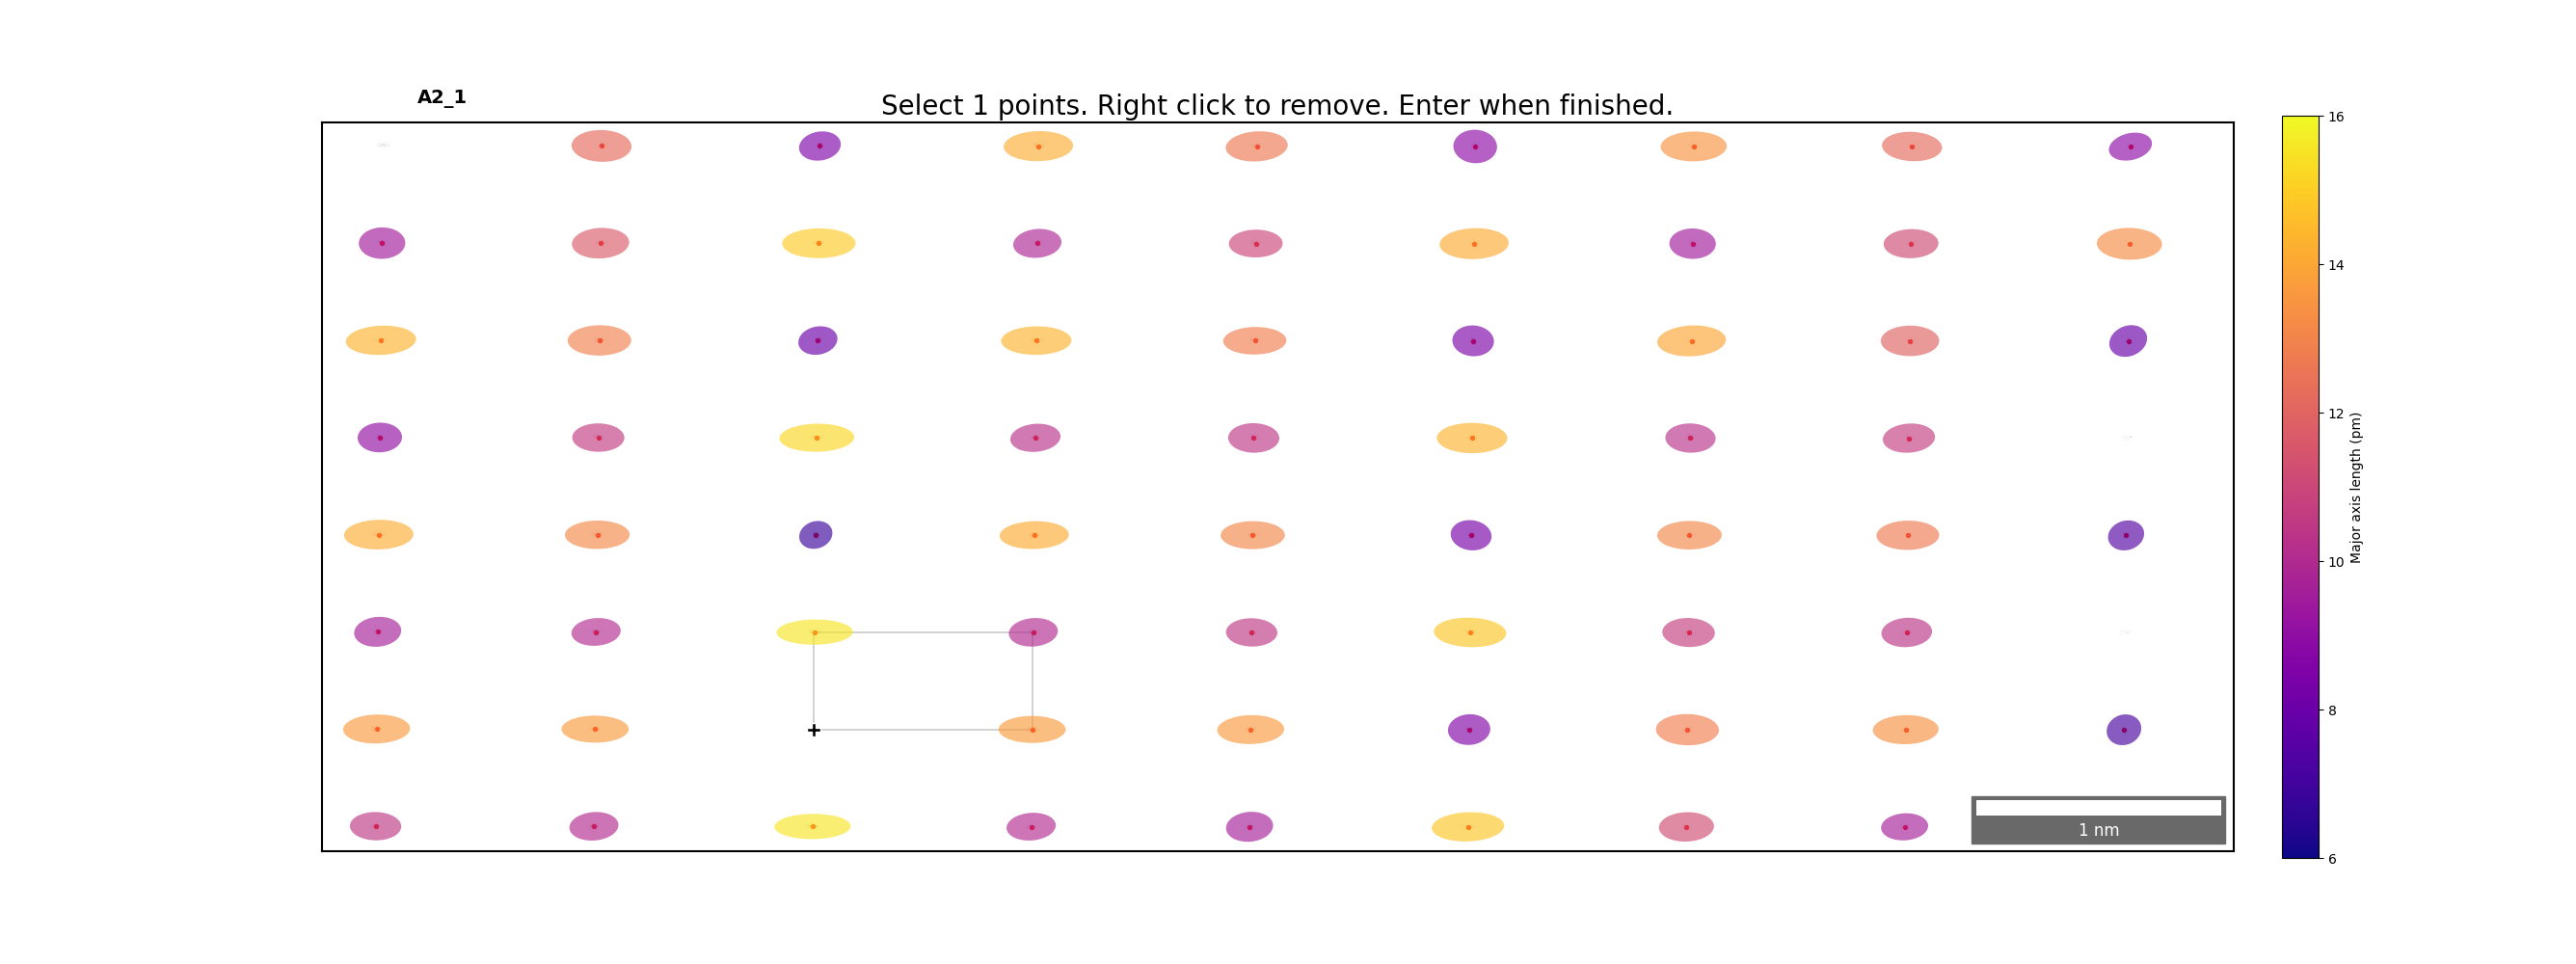

In [20]:
acl_rot.latt_dict['BSSN_rot'].vpcf_pick_peaks(
    'A2_1',
    n_picks=1,
    plot_equ_ellip=True,
)

- Now we use the chosen peak to find corresponding distances and plot them. Notice the ordering of the inter-column distances. It is not perfectly ordered but is still present.

Using pixel size:  0.065924705 Angstroms
Finding near neighbors...


  0%|          | 0/208 [00:00<?, ?it/s]

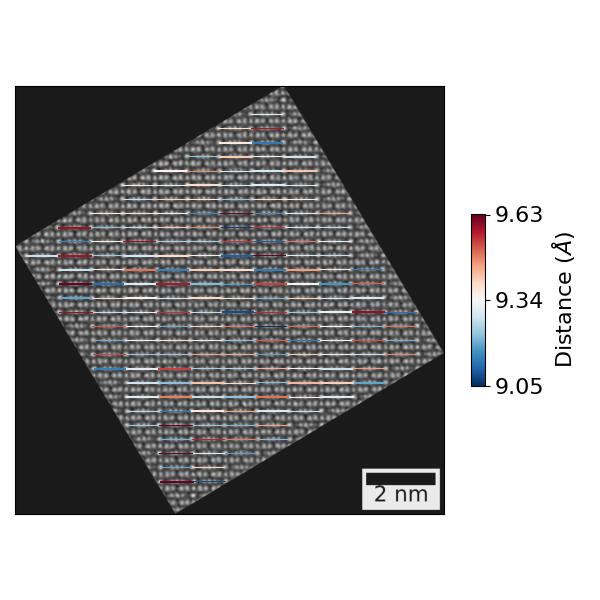

In [21]:
fig = acl_rot.latt_dict['BSSN_rot'].plot_vectors_on_image(
    r=.5,
    locate_by_fit_or_ref='ref',
    plot_fit_or_ref='fit',
    ref_vect=acl_rot.latt_dict['BSSN_rot'].dir_struct_matrix[0],
    vector_cmap_values='absolute',
    outlier_disp_cutoff=0.5,
    # xlim=[464, 2015],
    # ylim=[478, 2002],
    cmap='RdBu_r'
)

- Save atomic column position data to the master dictionary.

In [22]:
xy_fit = bssn_rot.at_cols.loc[:, 'x_fit': 'y_fit'].to_numpy() \
    - np.array([bssn_rot.x0, bssn_rot.y0])

uv_fit = xy_fit @ bssn_rot.dir_struct_matrix \
    / norm(bssn_rot.dir_struct_matrix, axis=1)**2

xy_agstr = uv_fit @ bssn_rot.a_2d

bssn_rot.at_cols['x_Agstr'] = xy_agstr[:, 0]
bssn_rot.at_cols['y_Agstr'] = xy_agstr[:, 1]

at_cols_frames[str(scan_num)] = bssn_rot.at_cols.copy()

- Write dicionary to a .csv file.

!!! Only run the following cell once all images are analized.

In [23]:
for key, df in at_cols_frames.items():
    df.to_csv(f'scan{key}_at_cols.csv')